In [2]:
from colorsys import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [4]:
def getQuantumColor(phi, theta):
    return hsv_to_rgb(phi/(np.pi*2), np.cos(theta/2)**0.5, np.sin(theta/2)**0.5)

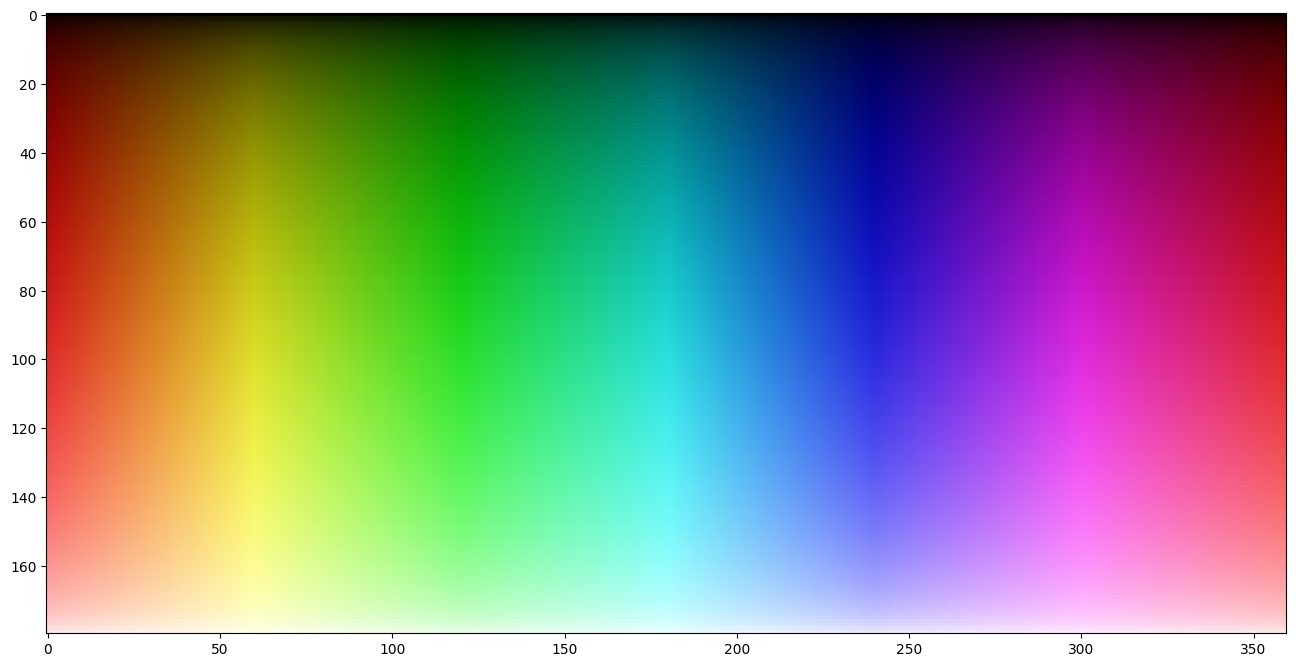

In [5]:
xSteps = 360
ySteps = 180

image = np.zeros((ySteps, xSteps, 3))


for x in range(xSteps):
    for y in range(ySteps):
        phi = x*np.pi*2/xSteps
        theta = y*np.pi/ySteps

        image[y, x] = getQuantumColor(phi, theta)


plt.figure(figsize=(16, 9))
plt.imshow(image)

In [26]:
def getCircuitCounts(qc: QuantumCircuit, noisy=False, shots = 1024):
    
    backend = FakeManilaV2() if noisy else AerSimulator()

    result = SamplerV2(backend).run([
        generate_preset_pass_manager(backend=backend, optimization_level=0)
            .run(qc)
    ], shots=shots).result()

    retDict = result[0].data.out.get_counts()
    for state in ['0', '1']:
        if state not in retDict.keys():
            retDict[state] = 0
    return retDict

In [24]:
def getQC(phi):
    qReg = QuantumRegister(1, 'Qubit')
    cReg = ClassicalRegister(1, 'out')
    qc = QuantumCircuit(qReg, cReg)
    
    qc.h(qReg)
    qc.rz(phi, qReg)
    qc.h(qReg)

    qc.measure(qReg, cReg)
    return qc

In [55]:
results = {}

nShots = 1000

for phi in np.linspace(0, 2*np.pi, 1000):
    results[phi] = getCircuitCounts(getQC(phi), shots=nShots)

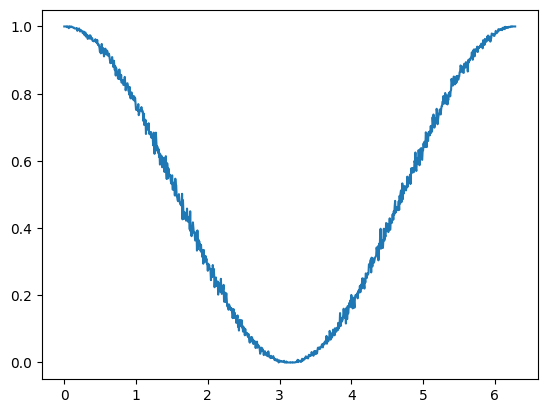

In [66]:
zeroFraction = { k: results[k]['0'] / ( results[k]['0'] + results[k]['1'] ) for k in results.keys()}
plt.plot(zeroFraction.keys(), zeroFraction.values())

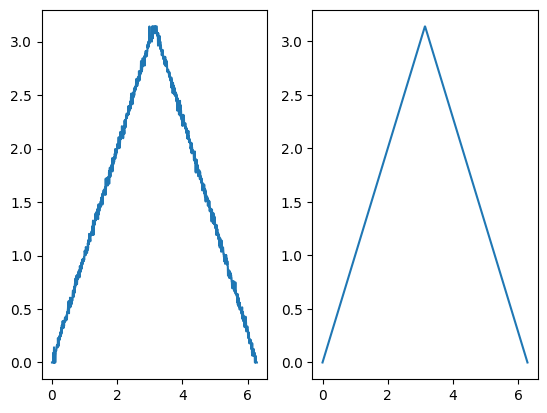

In [67]:
measuredAngles = { k:2*np.arccos(np.sqrt(zeroFraction[k])) for k in zeroFraction.keys() }

alpha = np.linspace(0, np.pi*2, 1000)

plt.subplot(121)
plt.plot(measuredAngles.keys(), measuredAngles.values())

plt.subplot(122)
plt.plot(alpha, np.arccos(np.cos(alpha)))

Not all the azimutal angle can be used, the fraction allows to restore only angles from 0 to π

/tmp/ipykernel_16777/1682523924.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


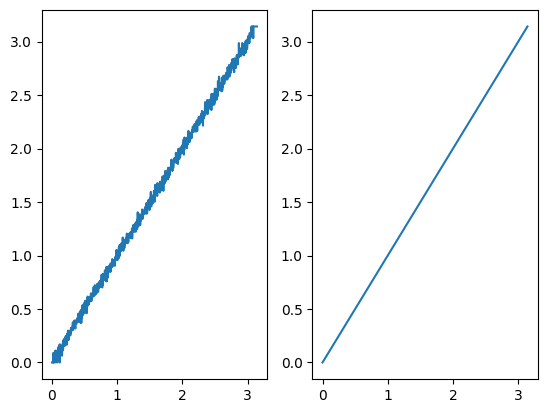

In [68]:
results = {}

for phi in np.linspace(0, np.pi, 1000):
    results[phi] = getCircuitCounts(getQC(phi))

In [76]:
noisyResults = {}

for phi in np.linspace(0, np.pi, 1000):
    noisyResults[phi] = getCircuitCounts(getQC(phi), noisy=True)

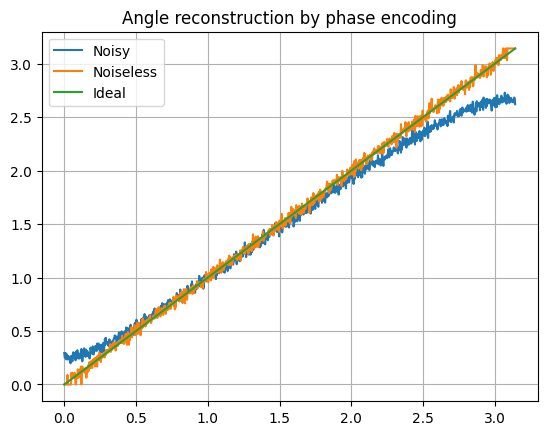

In [78]:
noisyMeasuredAngles = { k: 2*np.arccos(np.sqrt(noisyResults[k]['0'] / ( noisyResults[k]['0'] + noisyResults[k]['1'] ))) for k in noisyResults.keys()}
plt.plot(noisyMeasuredAngles.keys(), noisyMeasuredAngles.values())

measuredAngles = { k: 2*np.arccos(np.sqrt(results[k]['0'] / ( results[k]['0'] + results[k]['1'] ))) for k in results.keys()}
plt.plot(measuredAngles.keys(), measuredAngles.values())

alpha = np.linspace(0, np.pi, 1000)
plt.plot(alpha, np.arccos(np.cos(alpha)))

plt.title('Angle reconstruction by phase encoding')
plt.legend(['Noisy', 'Noiseless', 'Ideal'])
plt.grid()
plt.show()